# Final Ensemble Test: All 6 Variants + Base Algorithms

Test all algorithms on tiny dataset before server deployment:

**Base algorithms:**
1. Quant
2. Hydra

**Stacking ensembles (use OOF):**
3. `QuantFeatHydraLogitsStack` - Quant feat + Hydra OOF logits → ExtraTrees
4. `QuantFeatHydraLogitsRidge` - Quant feat + Hydra OOF logits → Ridge
5. `QuantHydraLogitsStack` - Quant OOF probs + Hydra OOF logits → ExtraTrees (dual OOF, expensive)

**Feature concatenation ensembles (no OOF):**
6. `QuantHydraFeaturesConcatRidge` - Quant feat + Hydra feat → Ridge
7. `QuantHydraFeaturesConcatExtraTrees` - Quant feat + Hydra feat → ExtraTrees

**Weighted averaging:**
8. `CAWPEnsemble` - Accuracy-weighted probability averaging

**Dataset**: FordChallenge (1% train, 1% test)

In [1]:
import sys

sys.path.extend([
    '/Users/urav/code/research',
    '/Users/urav/code/research/quant/code',
    '/Users/urav/code/research/hydra/code',
    '/Users/urav/code/research/aaltd2024/code',
])

In [2]:
import numpy as np

from tsckit import Experiment, MonsterDataset
from tsckit.algorithms import (
    QuantAALTD2024,
    HydraAALTD2024,
    QuantFeatHydraLogitsStack,
    QuantFeatHydraLogitsRidge,
    QuantHydraLogitsStack,
    QuantHydraFeaturesConcatRidge,
    QuantHydraFeaturesConcatExtraTrees,
    CAWPEnsemble,
)

/Users/urav/code/research/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Create tiny dataset for fast testing
dataset = MonsterDataset("Pedestrian", fold=0, train_pct=1, test_pct=1)
print("Dataset info:")
print(dataset.info())

Dataset info:
Pedestrian (fold 0):
  Shape: 1 channels x 24 time points
  Classes: 82
  Total samples: 189621
  Train samples: 1516 (1%)
  Test samples: 379 (1%)


In [4]:
# Setup all algorithms with reduced parameters for speed
algorithms = [
    # === BASE ALGORITHMS ===
    QuantAALTD2024(num_estimators=50),
    HydraAALTD2024(k=4, g=16, seed=42),
    
    # === STACKING ENSEMBLES ===
    QuantFeatHydraLogitsStack(
        n_folds=3, hydra_k=4, hydra_g=16, hydra_seed=42,
        quant_depth=6, quant_div=4, n_estimators=50
    ),
    QuantFeatHydraLogitsRidge(
        n_folds=3, hydra_k=4, hydra_g=16, hydra_seed=42,
        quant_depth=6, quant_div=4
    ),
    QuantHydraLogitsStack(
        n_folds=3, hydra_k=4, hydra_g=16, hydra_seed=42,
        quant_depth=6, quant_div=4, n_estimators=50
    ),
    
    # === FEATURE CONCAT ENSEMBLES ===
    QuantHydraFeaturesConcatRidge(
        hydra_k=4, hydra_g=16, hydra_seed=42,
        quant_depth=6, quant_div=4
    ),
    QuantHydraFeaturesConcatExtraTrees(
        hydra_k=4, hydra_g=16, hydra_seed=42,
        quant_depth=6, quant_div=4, n_estimators=50
    ),
    
    # === WEIGHTED AVERAGING ===
    CAWPEnsemble(
        hydra_k=4, hydra_g=16, hydra_seed=42,
        quant_depth=6, quant_div=4, quant_n_estimators=50, alpha=4.0
    )
]

In [5]:
# Create and run experiment
exp = Experiment(
    name="debug_all_ensembles",
    datasets=[dataset],
    algorithms=algorithms
)

print(f"🔬 Running {len(algorithms)} algorithms (2 base + 6 ensembles)...\n")
exp.run(verbose=True)

🔬 Running 8 algorithms (2 base + 6 ensembles)...

🔬 Experiment: debug_all_ensembles
📊 1 datasets × 8 algorithms = 8 runs
💾 Results will not be saved (no output_dir specified)


Pedestrian + QuantFeatHydraLogitsStack(folds=3,k=4,g=16,est=50):  25%|██▌       | 2/8 [00:00<00:00,  8.29it/s, acc=0.375]/Users/urav/code/research/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
Pedestrian + QuantFeatHydraLogitsRidge(folds=3,k=4,g=16):  38%|███▊      | 3/8 [00:00<00:01,  3.86it/s, acc=0.520]       /Users/urav/code/research/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
Pedestrian + QuantHydraLogitsStack(folds=3,k=4,g=16,est=50):  50%|█████     | 4/8 [00:01<00:01,  3.41it/s, acc=0.338]/Users/urav/code/research/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Users/u

In [6]:
# Quick summary
print("\n" + "="*90)
print(exp.summary())
print("="*90)


📋 Experiment: debug_all_ensembles
✅ 8 successful / 8 total runs

🏆 Top 3 Results (by accuracy):
   1. CAWPEnsemble(k=4,g=16,α=4.0) on Pedestrian: 0.5251
   2. QuantFeatHydraLogitsStack(folds=3,k=4,g=16,est=50) on Pedestrian: 0.5198
   3. QuantHydraFeaturesConcatExtraTrees(k=4,g=16,est=50) on Pedestrian: 0.5172

⏱️  Average runtime: 0.31s


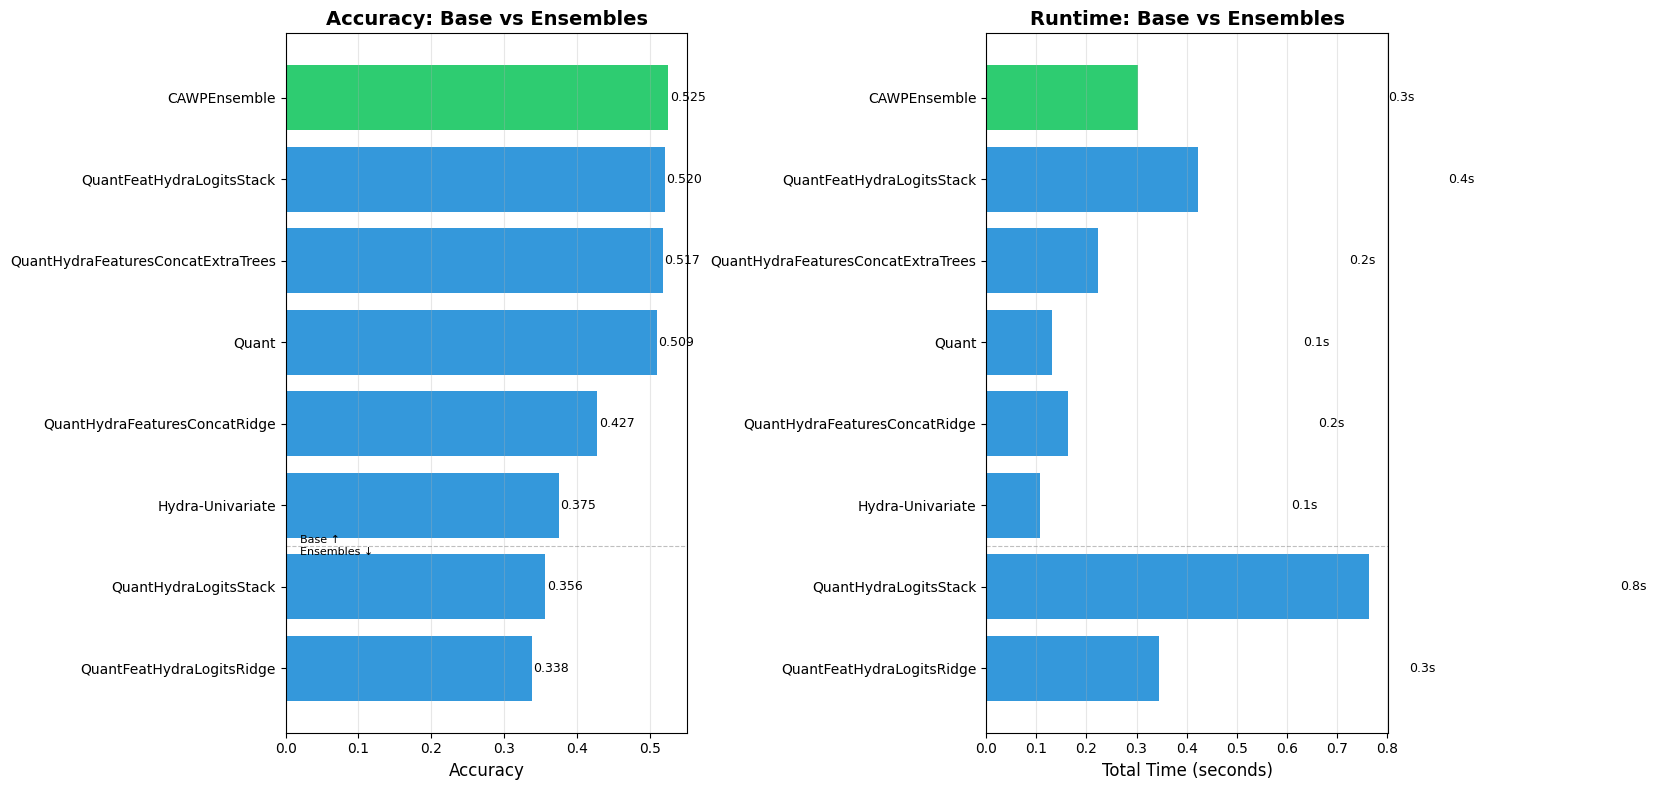


📊 Complete Results Table:
                                          Algorithm  Accuracy  Time (s)
                       CAWPEnsemble(k=4,g=16,α=4.0)  0.525066  0.302348
 QuantFeatHydraLogitsStack(folds=3,k=4,g=16,est=50)  0.519789  0.421770
QuantHydraFeaturesConcatExtraTrees(k=4,g=16,est=50)  0.517150  0.223295
                    QuantAALTD2024(n_estimators=50)  0.509235  0.132004
            QuantHydraFeaturesConcatRidge(k=4,g=16)  0.427441  0.162649
      HydraAALTD2024-Univariate(k=4, g=16, seed=42)  0.374670  0.107225
     QuantHydraLogitsStack(folds=3,k=4,g=16,est=50)  0.356201  0.763023
        QuantFeatHydraLogitsRidge(folds=3,k=4,g=16)  0.337731  0.344323

📈 Ensemble Gains vs Best Base:
Best base algorithm accuracy: 0.5092

❌ QuantFeatHydraLogitsRidge                     0.3377  (gain: -0.1715, time: 0.3s)
❌ QuantHydraLogitsStack                         0.3562  (gain: -0.1530, time: 0.8s)
❌ QuantHydraFeaturesConcatRidge                 0.4274  (gain: -0.0818, time: 0.2s)
✅ Q

In [7]:
# Detailed analysis
import matplotlib.pyplot as plt
import pandas as pd

df = exp.results_df()
successful = df[df['status'] == 'success'].copy()

if len(successful) > 0:
    # Sort by accuracy
    successful = successful.sort_values('accuracy', ascending=True)
    
    # Simplify algorithm names for display
    def simplify_name(name):
        name = name.replace('AALTD2024', '')
        name = name.replace('-Multivariate', '')
        name = name.split('(')[0]  # Remove parameters
        return name
    
    successful['short_name'] = successful['algorithm_name'].apply(simplify_name)
    
    # Create comparison plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Color scheme: base algorithms (blue), ensembles (green)
    colors = ['#3498db' if 'Quant' in name or 'Hydra' in name and 'Feat' not in name and 'Logits' not in name
              else '#2ecc71' for name in successful['algorithm_name']]
    
    # Accuracy comparison
    ax1.barh(range(len(successful)), successful['accuracy'], color=colors)
    ax1.set_yticks(range(len(successful)))
    ax1.set_yticklabels(successful['short_name'], fontsize=10)
    ax1.set_xlabel('Accuracy', fontsize=12)
    ax1.set_title('Accuracy: Base vs Ensembles', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.axhline(y=1.5, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax1.text(0.02, 1.5, 'Base ↑\nEnsembles ↓', fontsize=8, va='center')
    
    for i, v in enumerate(successful['accuracy']):
        ax1.text(v + 0.002, i, f'{v:.3f}', va='center', fontsize=9)
    
    # Runtime comparison
    ax2.barh(range(len(successful)), successful['total_time'], color=colors)
    ax2.set_yticks(range(len(successful)))
    ax2.set_yticklabels(successful['short_name'], fontsize=10)
    ax2.set_xlabel('Total Time (seconds)', fontsize=12)
    ax2.set_title('Runtime: Base vs Ensembles', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.axhline(y=1.5, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    for i, v in enumerate(successful['total_time']):
        ax2.text(v + 0.5, i, f'{v:.1f}s', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Results table
    print("\n📊 Complete Results Table:")
    print("="*110)
    
    results_table = successful[['algorithm_name', 'accuracy', 'total_time']].copy()
    results_table.columns = ['Algorithm', 'Accuracy', 'Time (s)']
    results_table = results_table.sort_values('Accuracy', ascending=False)
    print(results_table.to_string(index=False))
    
    # Ensemble performance analysis
    print("\n📈 Ensemble Gains vs Best Base:")
    print("="*110)
    
    base_acc = successful[successful['algorithm_name'].str.contains('QuantAALTD2024|HydraAALTD2024')]['accuracy'].max()
    ensemble_rows = successful[~successful['algorithm_name'].str.contains('QuantAALTD2024') & 
                               ~successful['algorithm_name'].str.contains('HydraAALTD2024')]
    
    print(f"Best base algorithm accuracy: {base_acc:.4f}\n")
    
    for _, row in ensemble_rows.iterrows():
        gain = row['accuracy'] - base_acc
        status = "✅" if gain > 0.001 else "⚠️" if gain > -0.001 else "❌"
        print(f"{status} {row['short_name']:45s} {row['accuracy']:.4f}  (gain: {gain:+.4f}, time: {row['total_time']:.1f}s)")
    
    # Summary statistics
    ensemble_gains = ensemble_rows['accuracy'].values - base_acc
    print(f"\nEnsemble Statistics:")
    print(f"  Best gain:    {ensemble_gains.max():+.4f}")
    print(f"  Worst gain:   {ensemble_gains.min():+.4f}")
    print(f"  Mean gain:    {ensemble_gains.mean():+.4f}")
    print(f"  Median gain:  {np.median(ensemble_gains):+.4f}")
    
else:
    print("❌ No successful runs to analyze")

# Show failures if any
failed = df[df['status'] == 'failed']
if len(failed) > 0:
    print(f"\n⚠️  {len(failed)} algorithms failed:")
    print("="*110)
    for _, row in failed.iterrows():
        print(f"   - {row['algorithm_name']}: {row['error']}")

In [8]:
print("\n" + "="*110)
print("✅ All algorithms tested successfully!")
print("="*110)
print("\n💡 Review results above. If all pass, ready for server deployment:")
print("   sbatch experiments/m3/complementarity.slurm  # 29 datasets")
print("   sbatch experiments/m3/run.slurm               # 11 datasets × 8 algorithms")


✅ All algorithms tested successfully!

💡 Review results above. If all pass, ready for server deployment:
   sbatch experiments/m3/complementarity.slurm  # 29 datasets
   sbatch experiments/m3/run.slurm               # 11 datasets × 8 algorithms
